# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

from functools import partial

from IPython.display import clear_output
from ocp import ILQR
from costs import *
import pdb
from utils import subsample

np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

In [57]:
class Biped():
    def __init__(self, m1 = 7, m2 = 7, m3 = 17,
                l1 = 0.5, l2 = 0.5, l3 = 0.35, g = 9.81, dT = 0.001, control_opt = 'std'):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.g = g
        self.dT = dT
        self.control_parameters = np.array([457.5, 161, 77.05, 5, 10.4*np.pi/180])  
        self.control_opt = control_opt
        self.Dx = 6
        self.Du = 2
       
    def set_control(self, control_opt = 'std', ilqr = None):
        self.control_opt = control_opt
        if control_opt == 'ilqr':
            self.ilqr = ilqr
            
        self.nn = NearestNeighbors(n_neighbors=1)
        self.nn.fit(ilqr.xs)

    def kin_hip(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_h = self.l1*sin(q[0])  
        z_h = self.l1*cos(q[0])  
        dx_h = self.l1*cos(q[0])*dq[0]  
        dz_h = -self.l1*sin(q[0])*dq[0]

        return x_h, z_h, dx_h, dz_h
    
    
    def compute_Jacobian_vhip(self, q, dq):
        J = np.zeros((2,6))
        J[0,0] = -self.l1*sin(q[0])*dq[0]
        J[0,3] = self.l1*cos(q[0])
        J[1,0] = -self.l1*cos(q[0])*dq[0]
        J[1,3] = -self.l1*sin(q[0])
        return J

    def kin_swf(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_swf = self.l1*sin(q[0]) - self.l2*sin(q[1])  
        z_swf = self.l1*cos(q[0]) - self.l2*cos(q[1])
        dx_swf = self.l1*cos(q[0])*dq[0] - self.l2*cos(q[1])*dq[1]  
        dz_swf = -self.l1*sin(q[0])*dq[0] + self.l2*sin(q[1])*dq[1]
        return x_swf, z_swf, dx_swf, dz_swf
    
    def compute_Jacobian_swf(self, q, dq = None):
        J = np.zeros((2,3))
        J[0,0] = self.l1*cos(q[0])
        J[0,1] = -self.l2*cos(q[1])
        J[1,0] = -self.l1*sin(q[0])
        J[1,1] = self.l2*sin(q[1])
        return J
    
    
    def eval_A_m(self, q_m):
        t2 = q_m[0]-q_m[1]
        t3 = cos(t2)
        t4 = self.l1**2
        t5 = self.m1*t4*0.25
        t6 = q_m[0] - q_m[2]
        t7 = cos(t6)
        t8 = self.l3**2
        m, m3 = self.m1, self.m3
        l1,l2,l3 = self.l1, self.l2, self.l3
        A_m = np.array([t5-l1*l2*m*t3-l1*l2*m3*t3-l1*l3*m3*t7*(1.0/2.0), 
                        t5,l1*l3*m3*t7*(-1.0/2.0),l2**2*m*(1.0/4.0),0.0,0.0,\
                        m3*t8*(-1.0/4.0)-l2*l3*m3*cos(q_m[1]-q_m[2])*(1.0/2.0),\
                        0.0,m3*t8*(-1.0/4.0)]).reshape(3,3).T
        return A_m
    
    def eval_A_p(self, q_p):
        q1_p = q_p[0]
        q2_p = q_p[1]
        q3_p = q_p[2]
        m, m3, l1, l2, l3 = self.m1, self.m3, self.l1, self.l2, self.l3
        
        t2 = l1**2;
        t3 = q1_p-q2_p;
        t4 = cos(t3);
        t5 = l1*l2*m*t4*(1.0/2.0);
        t6 = q1_p-q3_p;
        t7 = cos(t6);
        t8 = l2**2;
        t9 = l3**2;
        A_p = np.array([t5-m*t2*(5.0/4.0)-m3*t2-l1*l3*m3*t7*(1.0/2.0),t5,l1*l3*m3*t7*(-1.0/2.0),t5-m*t8*(1.0/4.0),
                       m*t8*(-1.0/4.0),0.0,m3*t9*(-1.0/4.0)-l1*l3*m3*t7*(1.0/2.0),0.0,m3*t9*(-1.0/4.0)]).reshape(3,3).T
        return A_p
    
    def eval_B(self):
        B = np.array([1.0,0.0,0.0, 1.0,-1.0,-1.0]).reshape(3,2)
        return B
    
    def eval_C(self, q, dq):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3 =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3

        t2 = q1-q2
        t3 = sin(t2)
        t4 = q1-q3
        t5 = sin(t4)
        C = np.array([0.0,dq1*l1*l2*m2*t3*(1.0/2.0),dq1*l1*l3*m3*t5*(-1.0/2.0),
                      dq2*l1*l2*m2*t3*(-1.0/2.0),0.0,0.0,dq3*l1*l3*m3*t5*(1.0/2.0),0.0,0.0]).reshape(3,3).T
        return C
    
    def eval_energy(self, q, dq):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        T = (dq1**2*l1**2*m1)/8 + (dq1**2*l1**2*m2)/2 + (dq1**2*l1**2*m3)/2 + (dq2**2*l2**2*m2)/8 + (dq3**2*l3**2*m3)/8 - (dq1*dq2*l1*l2*m2*cos(q1 - q2))/2 + (dq1*dq3*l1*l3*m3*cos(q1 - q3))/2;
        V = g*m2*(l1*cos(q1) - (l2*cos(q2))/2) + g*m3*(l1*cos(q1) + (l3*cos(q3))/2) + (g*l1*m1*cos(q1))/2;
        return T, V
    
    def eval_G(self, q):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g
        
        G = np.array([g*l1*sin(q1)*(m1+m2*2.0+m3*2.0)*(-1.0/2.0)
                      ,g*l2*m2*sin(q2)*(1.0/2.0),g*l3*m3*sin(q3)*(-1.0/2.0)])
        return G
    
    def eval_M(self, q):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        t2 = q1-q2;
        t3 = cos(t2);
        t4 = q1-q3;
        t5 = cos(t4);
        t6 = l1*l3*m3*t5*(1.0/2.0);
        M = np.array([l1**2*(m1*(1.0/4.0)+m2+m3),l1*l2*m2*t3*(-1.0/2.0),
                      t6,l1*l2*m2*t3*(-1.0/2.0),l2**2*m2*(1.0/4.0),0.0,
                      t6,0.0,l3**2*m3*(1.0/4.0)]).reshape(3,3)
        return M
    
    def impact(self, q_m, dq_m):
        q_p = np.array([q_m[1], q_m[0], q_m[2]])
        A_m = self.eval_A_m(q_m);
        A_p = self.eval_A_p(q_p);
        dq_p = np.linalg.pinv(A_p).dot(A_m).dot(dq_m)
        return q_p, dq_p
    
    def control(self, t, q, dq, parameters):
        kp1 = parameters[0];
        kp2 = parameters[1];
        kd1 = parameters[2];
        kd2 = parameters[3];
        alpha = parameters[4];

        y1 = q[2]-alpha;
        y1d = dq[2];
        y2 = -q[1]-q[0];
        y2d = -dq[1]-dq[0];

        u1 = kp1*y1 + kd1*y1d;

        u2 = kp2*y2 + kd2*y2d;

        u1 = max(min(u1, 30), -30) 
        u2 = max(min(u2, 30), -30) 
        u = np.array([u1, u2])
        return u
    
    def control_ilqr(self, t, y, t0):
        t_step = int((t- t0)/self.dT)
        #print(t_step)
        if t_step >= len(self.ilqr.K):
            t_step = len(self.ilqr.K)-1
        #calculate t_step based on the nearest neighbor
        #dist = np.linalg.norm(y - ilqr.xs, axis=1)
        #t_step = np.argmin(dist)
#         dist, idx = self.nn.kneighbors(y[None,:])
#         t_step = idx[0][0]
#         #print(t_step)
#         if t_step >= len(self.ilqr.K):
#             t_step = len(self.ilqr.K)-1
        
        u = self.ilqr.us[t_step] + self.ilqr.K[t_step].dot(y-self.ilqr.xs[t_step])
        #u = np.zeros(self.Du)
        return u
    
    def eqns(self, t, y, t0,  parameters):    
        q = y[:3]
        dq = y[3:]
        
        M = self.eval_M(q)
        C = self.eval_C(q, dq)
        G = self.eval_G(q)
        B = self.eval_B()
        if self.control_opt == 'std':
            u = self.control(t, q, dq, parameters)
        else:
            u = self.control_ilqr(t, y, t0)
            
        n = 6
        dy = np.zeros(n)
        dy[:3] = y[3:]
        #dy[3:] = np.linalg.inv(M).dot(-C.dot(dq) - G + B.dot(u))
        dy[3:] = np.linalg.solve(M, -C.dot(dq) - G + B.dot(u))
        return dy
    
    def step(self, y, u):
        q = y[:3]
        dq = y[3:]
        M = self.eval_M(q)
        C = self.eval_C(q, dq)
        G = self.eval_G(q)
        B = self.eval_B()
        dy = np.zeros(6)
        dy[:3] = y[3:]
        dy[3:] = np.linalg.solve(M, -C.dot(dq) - G + B.dot(u))
        ynext = y + dy*self.dT
        return ynext
    
    def compute_matrices(self, y, u, inc = 1e-3):
        Dx = len(y)
        Du = len(u)
        A = np.zeros((Dx, Dx))
        B = np.zeros((Dx, Du))
        
        #compute A
        y0, u0 = y.copy(), u.copy()
        for i in range(Dx):
            y0p = y0.copy()
            y0p[i] += inc
            dyp = self.step(y0p,u0)

            y0m = y0.copy()
            y0m[i] -= inc
            dym = self.step(y0m,u0)
            
            diff = (dyp - dym)/(2*inc)
            
            A[:,i] = diff
            
        #compute B
        y0, u0 = y.copy(), u.copy()
        for i in range(Du):
            u0p = u0.copy()
            u0p[i] += inc
            dup = self.step(y0,u0p)

            u0m = u0.copy()
            u0m[i] -= inc
            dum = self.step(y0,u0m)
            
            diff = (dup - dum)/(2*inc)
            
            B[:,i] = diff
            
        return A, B
            
    def solve_eqns(self, q0, dq0, num_steps, parameters, retrain = False):
        
        #options = odeset('RelTol',1e-5, 'Events', @event_func);
        h = self.dT; # time step
        tmax = 2; # max time that we allow for a single step
        tspan = np.arange(0, tmax, h)
        y0 = np.concatenate([q0, dq0])
        t0 = 0

        sln = {'T' : [], 'Y' : [], 'TE' : [], 'YE' : []}
        
        for i in range(num_steps):
            tic = time.time()
            eqns_std = partial(biped.eqns, t0 = t0, parameters = parameters )
            if self.control_opt == 'ilqr' and retrain == True:
                self.ilqr.set_init_state(y0.copy())
                self.set_init_state(y0.copy())
                #us = np.zeros((self.ilqr.T+1, self.Du))
                x = y0.copy()
                us = []
                for k in range(self.ilqr.T+1):
                    u = self.control(0, x[:3], x[3:], params)
                    x = self.step(x, u)
                    us += [u]
                us = np.array(us)
                xs = self.rollout(us)
                us = np.concatenate([us, np.zeros((1, self.Du))], axis=0)
                #xs[0] = y0.copy()
                self.ilqr.set_state(xs, us)
                self.ilqr.solve(10)
                clear_output()
            print(y0, t0)
            print(tspan, np.arange(t0, t0+tmax-1e-4, h))
            tspan = np.arange(t0, t0+tmax-1e-4, h)
            sol = solve_ivp(eqns_std, (t0, t0+tmax),  y0, t_eval = np.arange(t0, t0+tmax-1e-4, h), events = event_func, rtol = 1e-5)            
            toc = time.time()
            print(len(sol.t))
            sln['T'] += [sol.t]
            sln['Y'] += [sol.y.T]
            sln['TE'] += [sol.t_events]

            if np.abs(sol.t[-1]- tmax) < 1e-4:
                break

            if len(sol.t_events) == 0:
                break

            # Impact map
            q_m = sol.y.T[-1,:3]
            dq_m = sol.y.T[-1,3:]
            q_p, dq_p = self.impact(q_m, dq_m)

            y0 = np.concatenate([q_p, dq_p])
            t0 = sol.t[-1]
            tspan = np.arange(t0, t0+tmax-1e-4, h)
            print(tspan)
        return sln
    
    def analyse(self, sln, parameters,  to_plot = True, Umax = 30):
        x_hs = []
        dx_hs_mean = []
        dx_hs = []

        z_hs = []
        dz_hs = []
        
        z_swfs = []
        dz_swfs = []
        

        qs = []
        dqs = []
        us = []

        t_hs = []

        fs = []
        ds = []
        effort = 0
        cot = 0
        
        for i in range(len(sln['Y'])):
            Y = sln['Y'][i]
            T = sln['T'][i]
            t0 = T[0]
            t_hs += [T]
            dt = T[-1] - T[0]
            f = 1.0/dt
            fs += [f]

            for j in range(len(Y)):
                t = T[j]
                y = Y[j]
                x_h, z_h, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
                x_hs += [x_h]
                dx_hs += [dx_h]
                z_hs += [z_h]
                dz_hs += [dz_h]

                x_swf, z_swf, dx_swf, dz_swf =  self.kin_swf(y[:3], y[3:])
                z_swfs += [z_swf]
                
                
                qs += [y[:3]]
                dqs += [y[3:]]
                if self.control_opt == 'std':
                    u = self.control(t, y[:3], y[3:],parameters);
                elif self.control_opt == 'ilqr':
                    u = self.control_ilqr(t, y, t0);
                    
                us += [u]

            y = Y[0]
            x_h0, z_h0, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
            y = Y[-1]
            x_hT, z_hT, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
            d = x_hT - x_h0
            ds += [d]

            dx_hs_mean += [d/dt]

        results = dict();
        results['x_h'] = np.array(x_hs)
        results['dx_h'] = np.array(dx_hs)
        results['z_h'] = np.array(z_hs)
        results['dz_h'] = np.array(dz_hs)
        results['z_swf'] = np.array(z_swfs)
        results['t_h'] = np.concatenate(t_hs)
        
        results['qs'] = np.array(qs)
        results['dqs'] = np.array(dqs)
        results['us'] = np.array(us)

        results['fs'] = np.array(fs)
        results['ds'] = np.array(ds)
        
        T = results['t_h'][-1]
        results['effort'] = np.sum(results['us'][:,0]**2 + results['us'][:,1]**2)/(2*T*Umax)
        results['cot'] = results['effort']/np.sum(results['ds'])

        results['dx_hs_mean'] = np.array(dx_hs_mean)
        results['mean_velocity'] = np.sum(results['ds'])/T
        
        if to_plot:
            plt.figure()
            plt.plot(results['t_h'], (results['x_h']))
            plt.title('xh')
            plt.figure()
            plt.plot(results['t_h'], (results['z_h']))
            plt.title('zh')
            for j in range(3):
                plt.figure()
                plt.plot(results['qs'][:,j], results['dqs'][:,j])
                plt.title('phase plot '+str(j))
            
            plt.figure()
            plt.plot(results['t_h'], (results['dx_h']))
            plt.title('dxh')

            plt.figure()
            plt.plot(results['t_h'], (results['z_swf']))
            plt.title('z_swf')
            
#             plt.figure()
#             plt.plot((results['dx_hs_mean']))
#             plt.title('dhh_mean')

#             plt.figure()
#             plt.plot((results['fs'][1:]), '-o')
#             plt.title('fs')
            
#             plt.figure()
#             plt.plot((results['ds'][0:]), '-o')
#             plt.title('ds')

#             for j in range(2):
#                 plt.figure()
#                 plt.plot(results['t_h'], (results['us'][:,j]))
#                 plt.title('us'+str(j))

            
        return results
    
    def visualize(self, q, r0 = None, fig = None, figsize = (10,10)):
        if fig is None:     
            if self.fig is None: self.fig = plt.figure(figsize=figsize)
        else:
            self.fig = fig
        if r0 is None: r0 = np.zeros(2)

        x0 = r0[0];
        z0 = r0[1];

        l1, l2, l3 = self.l1, self.l2, self.l3 
        q1, q2, q3 = q[0], q[1], q[2]

        x1 = (l1*sin(q1))/2 + x0;
        z1 = (l1*cos(q1))/2 + z0;
        x2 = l1*sin(q1) - (l2*sin(q2))/2 + x0;
        z2 = l1*cos(q1) - (l2*cos(q2))/2 + z0;
        x3 = l1*sin(q1) + (l3*sin(q3))/2 + x0;
        z3 = l1*cos(q1) + (l3*cos(q3))/2 + z0;

        x_h = l1*sin(q1) + x0;
        z_h = l1*cos(q1) + z0;

        x_t = l1*sin(q1) + l3*sin(q3) + x0;
        z_t = l1*cos(q1) + l3*cos(q3) + z0;

        x_swf = l1*sin(q1) - l2*sin(q2) + x0;
        z_swf = l1*cos(q1) - l2*cos(q2) + z0;

        lw = 5;
        # links
        if self.line1 is None:
            self.line1, = plt.plot([x0, x_h], [z0, z_h], linewidth = lw); 
            self.line2, = plt.plot([x_h, x_t], [z_h, z_t], linewidth = lw); 
            self.line3, = plt.plot([x_h, x_swf], [z_h, z_swf], linewidth = lw);
            # plot a line for "ground"
            self.lineg, = plt.plot([-1 + x_h, 1 + x_h], [0, 0], 'b');
            plt.axis('equal')
            plt.xlim([-1 + x_h, 1 + x_h]);
            plt.ylim([-0.8, 1.2]);
            # point masses
            mz = 15;
            self.marker1, = plt.plot(x1, z1, '.', markersize = mz); 
            self.marker2, = plt.plot(x2, z2, '.',  markersize = mz); 
            self.marker3, = plt.plot(x3, z3, '.',  markersize = mz);
        else:
            self.line1.set_xdata([x0, x_h])
            self.line1.set_ydata([z0, z_h])
            self.line2.set_xdata([x_h, x_t])
            self.line2.set_ydata([z_h, z_t])
            self.line3.set_xdata([x_h, x_swf])
            self.line3.set_ydata([z_h, z_swf])
            self.marker1.set_xdata(x1)
            self.marker1.set_ydata(z1)
            self.marker2.set_xdata(x2)
            self.marker2.set_ydata(z2)
            self.marker3.set_xdata(x3)
            self.marker3.set_ydata(z3)          
            self.lineg.set_xdata( [-1 + x_h, 1 + x_h])
            self.lineg.set_ydata( [0, 0])
            plt.xlim([-1 + x_h, 1 + x_h]);
            self.fig.canvas.draw()
            plt.pause(1e-6)
            self.fig.canvas.flush_events()
        
    def animate(self, sln, dt = 0.01, skip = 10):
        tic = time.time();
        self.line1, self.line2, self.line3 = None, None, None
        self.marker1, self.marker2, self.marker3 = None, None, None
        self.fig = plt.figure(figsize=(10,10))

        num_steps = len(sln['T'])
        r0 = np.zeros(2)
        for j in range(num_steps):
            Y = sln['Y'][j]
            N = len(Y)
            for i in range(0, N, skip):
                q = Y[i, :3]
                time.sleep(dt)
                self.visualize(q, r0, fig = self.fig)
            x0, _,_,_ = self.kin_swf(q)
            r0 = r0 + np.array([x0, 0])

        toc = time.time()
        
        real_time_factor = sln['T'][-1][-1] / (toc-tic)
        print('Real time factor:{}'.format(real_time_factor))
        return real_time_factor
    
    def set_init_state(self,x0):
        self.x0 = x0

    
    def rollout(self,us):
        x_cur = self.x0.copy()
        xs = [x_cur]
        T = len(us)
        for i in range(T):
            x_cur = self.step(x_cur, us[i])
            xs += [x_cur]
        return np.array(xs)
    
def event_func(t, y):
    q = y[:3]
    dq = y[3:]

    _, z_swf, _,_ = biped.kin_swf(q, dq)
    value = z_swf + 0.01* cos(q[0]) + 0.0001
    return value
event_func.terminal = 1
event_func.direction = -1

In [58]:
from sklearn.neighbors import NearestNeighbors

#### Try solving and analyse result

In [59]:
%matplotlib qt

In [60]:
biped = Biped()
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

In [61]:
sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)
clear_output()

In [62]:
res = biped.analyse(sln, biped.control_parameters, to_plot=False)

In [63]:
res['cot']

2060.8294346549337

#### Try optimizing

### Observe the resulting initial and final configs

In [64]:
Y = np.array(sln['Y'])

y0 = []
yT = []
for i in range(len(Y)):
    y0 += [Y[i][0]]
    yT += [Y[i][-1]]
y0 = np.array(y0)
yT = np.array(yT)

q0, dq0 = y0[-1,:3], y0[-1,3:]
qT, dqT = yT[-1,:3], yT[-1,3:]
T = sln['T'][-1][-1] - sln['T'][-1][0]

params = biped.control_parameters
T = 0.375

In [66]:
sln = biped.solve_eqns(q0, dq0, 5, params)
clear_output()

In [67]:
res = biped.analyse(sln, params, to_plot=False)

In [68]:
print(res['cot'])

3598.1243224599807


### One step motion using standard controller

In [69]:
y0 = np.concatenate([q0, dq0])
yT = np.concatenate([qT, dqT])

In [70]:
y = y0.copy()
ys = [y]
us = []
zswfs = []
x_h0, _,_,_ = biped.kin_hip(y[:3])
for h in range(int(T/0.001)):
    u = biped.control(0, y[:3], y[3:],params)
    y = biped.step(y, u)
    _,z_swf,_,_ = biped.kin_swf(y[:3])
    zswfs += [z_swf]
    ys += [y]
    us += [u]
    
x_hT , _,dx_hT,dz_hT = biped.kin_hip(y[:3])
dist = x_hT-x_h0
ys = np.array(ys)
us = np.array(us)
zswfs = np.array(zswfs)

In [71]:
fig = plt.figure(figsize=(10,10))
biped.fig = fig
biped.line1 = None
for y in ys[::10]:
    biped.visualize(y[:3], fig=fig)
    time.sleep(0.001)

#### Evaluate

In [72]:
effort = np.sum(us[:,0]**2 + us[:,1]**2)/(2*T*30)
cot = effort / dist
print(effort, cot)

(5870.379863487107, 18047.395348870734)


## Try ILQR

In [73]:
Tc = int(T/biped.dT)
dt = biped.dT

In [74]:
x_ref = yT.copy()
x0 = y0.copy()
biped.set_init_state(x0)
xs = biped.rollout(us)

In [75]:
xs = subsample(xs, Tc+1)
us = subsample(us, Tc+1)

#### Define cost

In [76]:
x_ref[2] = 0.2487

In [111]:
Q = np.eye(biped.Dx)*0.1
# Q[0,1] = 100.
# Q[1,0] = -100.
Q[2,2] = 100
Qf = np.eye(biped.Dx)*10
R = np.eye(biped.Du)*.01
mu = 1e-6

#swing trajectory
Wt = np.eye(2)*5000
Wt[0,0] = 0
z_refs = np.linspace(0.01, -.00, Tc)

#end foot traj
WT = np.eye(2)*5000
p_ref = np.array([0.31, -0.01])

#velocity of hip
Wv = np.eye(2)*0
#Wv[1,1] *= 0.01
v_ref = np.array([.8, 0])

costs = []
for i in range(Tc):
    runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost,terminalEEVelCost ])
costs += [terminalCost]



# runningStateCost = CostModelQuadratic(biped, Q, x_ref = x_ref)
# runningControlCost = CostModelQuadratic(biped, None, R)
# # runningEEVelCost = CostModelQuadraticLinVel(biped, 0.001*Wv, p_ref = v_ref)
# #runningCost = CostModelSum(biped, [runningStateCost, runningControlCost, runningEEVelCost])
# runningCost = CostModelSum(biped, [runningStateCost, runningControlCost])

# terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
# terminalControlCost = CostModelQuadratic(biped, None,R)
# # terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
# terminalEECost = CostModelQuadraticTranslation(biped, W, p_ref = p_ref)
# terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
# costs = [runningCost]*Tc + [terminalCost]

#### Setting cost

# costs = []
# for i in range(Tc):
#     runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = ys[i].copy())
#     runningControlCostShort = CostModelQuadratic(biped, None, R)
#     runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort])        
#     costs += [runningCostShort]
    
# terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
# terminalControlCost = CostModelQuadratic(biped, None,R)
# terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost])
# costs += [terminalCost]

#### Define iLQR

In [112]:
us = np.concatenate([us, np.zeros((1, biped.Du))], axis=0)

In [113]:
ilqr = ILQR(biped)
ilqr.set_init_state(x0)
ilqr.set_timestep(Tc)
ilqr.set_cost(costs)

In [114]:
ilqr.set_state(xs, us)
ilqr.solve(10)
clear_output()
xs, us = ilqr.xs, ilqr.us

In [115]:
plt.plot(ilqr.us[:,0])


In [116]:
biped.kin_swf(xs[-1][:3])

(0.3025841028991577, -0.00775396652384569, 0.0, -0.0)

In [117]:
print(xs[-1])
print(x_ref)
p_ref

[ 0.3331 -0.2819  0.2688  2.3408 -1.4604 -0.1821]
[ 0.3621 -0.3043  0.2487  2.4521 -1.8659 -0.2882]


array([ 0.31, -0.01])

In [118]:
fig = plt.figure(figsize=(10,10))
biped.fig = fig
biped.line1 = None
zswfs = []

for y in xs[::10]:
    biped.visualize(y[:3], fig=fig)
    time.sleep(0.01)
    _,z_swf,_,_ = biped.kin_swf(y[:3])
    zswfs += [z_swf]
zswfs = np.array(zswfs)


In [119]:
plt.plot(zswfs)

#### Evaluate

### One step motion using ilqr controller

In [120]:
biped.set_control('ilqr', ilqr)

In [121]:
y0 = np.concatenate([q0, dq0])
yT = np.concatenate([qT, dqT])

In [122]:
y = y0.copy()
ys = [y]
us = []
zswfs = []
x_h0, _,_,_ = biped.kin_hip(y[:3])
for h in range(int(T/biped.dT)):
    u = biped.control_ilqr(h*biped.dT, y, 0)
    y = biped.step(y, u)
    _,z_swf,_,_ = biped.kin_swf(y[:3])
    zswfs += [z_swf]
    ys += [y]
    us += [u]
    
x_hT , _,_,_ = biped.kin_hip(y[:3])
dist = x_hT-x_h0
#ys = np.array(ys)
#us = np.array(us)
#zswfs = np.array(zswfs)
clear_output()

In [123]:
%matplotlib inline

In [124]:
sln = biped.solve_eqns(q0, dq0,1, params)
clear_output()

In [125]:
res_ys = sln['Y'][0]

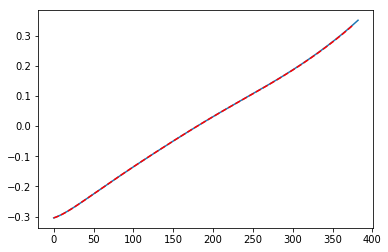

In [126]:
idx = 0
plt.plot(res_ys[:,idx])
plt.plot(ilqr.xs[:,idx], '--r')

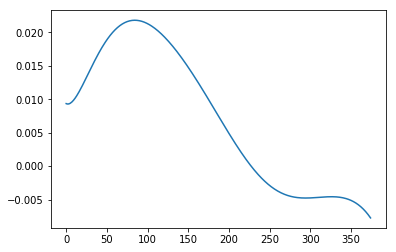

In [127]:
plt.plot(zswfs)

In [128]:
%matplotlib qt

In [129]:
fig = plt.figure(figsize=(10,10))
biped.fig = fig
biped.line1 = None
ys = np.array(ys)
us = np.array(us)
for y in ys[::10]:
    biped.visualize(y[:3], fig=fig)
    time.sleep(0.005)

#### retrain the iLQR

#### Try simulation with ilqr

In [130]:
sln = biped.solve_eqns(q0, dq0,5, params, True)
clear_output()

In [131]:
biped.animate(sln)

Real time factor:0.302473557188


0.3024735571882456

In [55]:
res = biped.analyse(sln, params, False)

In [56]:
print(res['cot'])

3507.9326791901904


In [1401]:
q0n, dq0n = y0n[:3], y0n[3:]

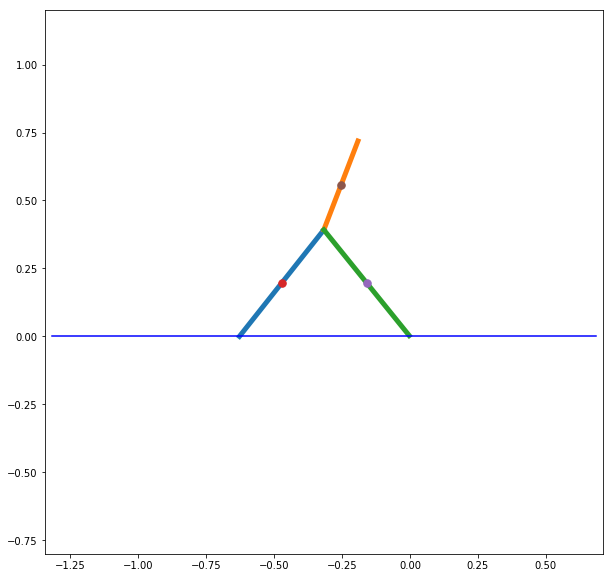

In [1402]:
sln2 = biped.solve_eqns(q0n, dq0n, 2, params);
%matplotlib qt
biped.animate(sln2)
clear_output()

In [157]:
y = y0n.copy()
ys = [y]
us = []
zswfs = []
x_h0, _,_,_ = biped.kin_hip(y[:3])
for h in range(int(2.*T/biped.dT)):
    u = biped.control_ilqr(h*biped.dT, y, 0)
    y = biped.step(y, u)
    _,z_swf,_,_ = biped.kin_swf(y[:3])
    zswfs += [z_swf]
    ys += [y]
    us += [u]
    
x_hT , _,_,_ = biped.kin_hip(y[:3])
dist = x_hT-x_h0
ys = np.array(ys)
us = np.array(us)
zswfs = np.array(zswfs)
clear_output()

In [158]:
fig = plt.figure(figsize=(10,10))
biped.fig = fig
biped.line1 = None
for y in ys[::10]:
    biped.visualize(y[:3], fig=fig)
    time.sleep(0.005)

#### Compare against matlab